# Import Libs

In [1]:
import io
import os
import shutil
import datetime
import numpy as np
import seaborn as sns
import tensorflow as tf 
import matplotlib.pylab as plt 
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import confusion_matrix, roc_curve,f1_score
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, FalsePositives, FalseNegatives, TrueNegatives,Precision,Recall, AUC
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, BatchNormalization, Input, Layer,Dropout,
                                     RandomFlip, RandomRotation, Resizing, Rescaling #for augmentation
                                     )

In [2]:
tf.__version__

'2.10.0'

# Load Malaria Dataset

In [3]:
dataset, dataset_info = tfds.load('malaria',with_info=True, as_supervised=True, shuffle_files = True, split = 'train')

In [4]:
tfds.__version__

'4.9.2'

# Data Split

In [5]:
TRANI_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [6]:
def splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRANI_RATIO*DATASET_SIZE))
    val_test__dataset = dataset.skip(int(TRANI_RATIO*DATASET_SIZE))
    val_dataset = val_test__dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset = val_test__dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset


In [7]:
#dataset = tf.data.Dataset.range(20)
train_dataset, val_dataset, test_dataset = splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO)

# Data Visualizing

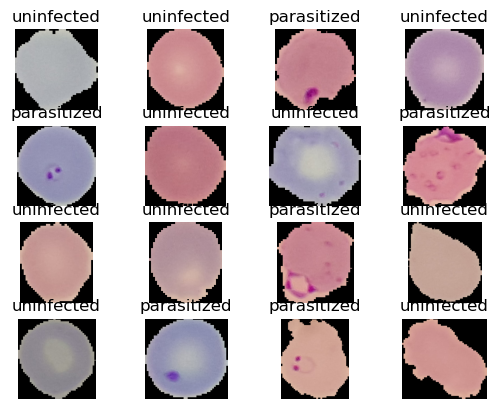

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [9]:
 dataset_info.features['label'].int2str(0)

'parasitized'

# Augmentation

## tf.image augment

In [10]:
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0,label

In [11]:
IM_SIZE = 224

In [12]:
## tf.image augment
def augment(image, label):
    image, label = resize_rescale(image, label)
    image = tf.image.rot90(image)
    image = tf.image.flip_left_right(image)
    return image, label

In [13]:
class RotNinty(Layer):
  def __init__(self):
    super().__init__()
  def call(self, image):
    return tf.image.rot90(image)

## tf.keras.layers

In [14]:
resizing_rescaling_layers = tf.keras.Sequential([
    Resizing(IM_SIZE,IM_SIZE),
    Rescaling(1.0/255)
])

In [15]:
## tf.keras.layers augment
augment_layers = tf.keras.Sequential([
    RotNinty(),
    RandomFlip(mode='horizontal', )
])

def augment_layer(image, label):
  return augment_layers(resizing_rescaling_layers(image), training = True), label

## Mixup Augmentation

In [16]:
train_dataset_1 = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration= True).map(resize_rescale)
train_dataset_2 = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration= True).map(resize_rescale)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [17]:
def mixup(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]
    
    image = lamda*image_1 + (1- lamda *image_2)
    label = lamda*tf.cast(label_1, dtype = tf.float32) + (1 - lamda * tf.cast(label_2, dtype = tf.float32))

    return image, label

# Data Preprocessing

In [18]:
BATCH_SIZE = 32
train_dataset = (mixed_dataset
                 .shuffle(buffer_size= 8 , reshuffle_each_iteration= True)
                 .map(mixup) # augmentation with mixup
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset
               .shuffle(buffer_size= 8 , reshuffle_each_iteration= True)
                .map(resize_rescale) # Just resizing and rescaling 
               .batch(BATCH_SIZE)
               .prefetch(tf.data.AUTOTUNE))

test_dataset = test_dataset.map(resize_rescale)

# Model Subclassing

In [19]:
class FeatureExtractor(Layer):
    def __init__(self, num_filters, kernel_size,num_strides, padding, activation_function, pool_size, droupout_rate, regularizer_rate):
        super(FeatureExtractor, self).__init__()
        self.conv_1 = Conv2D(filters= num_filters,kernel_size=kernel_size, strides=num_strides, padding= padding, activation = activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_1 = BatchNormalization()
        self.droupout1 = Dropout(rate = droupout_rate)
        self.pool_1 = MaxPooling2D(pool_size=pool_size, strides=num_strides)

        self.conv_2 = Conv2D(filters= 2*num_filters,kernel_size=kernel_size, strides=num_strides, padding= padding, activation = activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPooling2D(pool_size=pool_size, strides=2*num_strides)

    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.droupout1(x)
        x = self.pool_1(x)


        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)

        return x

In [20]:
feature_sub_classed = FeatureExtractor(num_filters = 8, kernel_size = 3,num_strides = 1, padding= "valid", activation_function = "relu", pool_size = (2,2), droupout_rate = 0.3, regularizer_rate = 0.01)

In [21]:
class LenetModel(Model):
    def __init__(self, num_filters, kernel_size,num_strides, padding, activation_function, pool_size, output_activation,droupout_rate, regularizer_rate):
        super(LenetModel, self).__init__()

        self.resizing_layer = Resizing(224, 224)
        self.rescaling_layer = Rescaling(1.0 / 255)
        self.featureExtractor = FeatureExtractor(
                                    num_filters = num_filters,
                                    kernel_size = kernel_size,
                                    num_strides = num_strides,
                                    padding = padding,
                                    activation_function = activation_function,
                                    pool_size = pool_size,
                                    droupout_rate = droupout_rate,
                                    regularizer_rate = regularizer_rate)
        self.flatten = Flatten()

        self.dense_1 = Dense(units = 100, activation=activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_1 = BatchNormalization()
        self.droupout1 = Dropout(rate = droupout_rate)
        self.dense_2 = Dense(units = 10, activation=activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_2 = BatchNormalization()

        self.dense_3 = Dense(units=1, activation = output_activation)

    def call(self, x, training):
        x = self.resizing_layer(x)
        x = self.rescaling_layer(x)
        x = augment_layers(x)

        x = self.featureExtractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.droupout1(x)

        x = self.dense_2(x)
        x = self.batch_2(x)

        x = self.dense_3(x)

        return x

In [22]:
lenet_model = LenetModel(num_filters = 8, kernel_size = 3,num_strides = 1, padding= "valid", activation_function = "relu", pool_size = (2,2),
                         output_activation = "sigmoid", droupout_rate = 0.3, regularizer_rate=0.01)
lenet_model(Input(shape= (None, None,3)))
lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       multiple                  0         
                                                                 
 rescaling_1 (Rescaling)     multiple                  0         
                                                                 
 feature_extractor_1 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  19009700  
                                                                 
 batch_normalization_4 (Batc  multiple                 400       
 hNormalization)                                       

# Optimizers

In [23]:
metrics = [TruePositives(name='tp'), FalsePositives(name= 'fp'), FalseNegatives(name= 'fn'), TrueNegatives(name='tn'),
          BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [24]:
lenet_model.compile(optimizer=Adam(learning_rate=0.1), loss=BinaryCrossentropy(), metrics= metrics,)

# Callbacks

In [25]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

    def no_batch_end(self, batch, logs):
        print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

In [26]:
test_dataset2 = test_dataset.batch(1)

In [27]:
class LogImagesCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        labels = []
        inp = []
        for x,y in test_dataset2.as_numpy_iterator():
            labels.append(y)
            inp.append(x)
        
        labels = np.array([i[0] for i in labels])
        predicted = lenet_model.predict(np.array(inp)[:,0,...])

        threshold = 0.5

        cm = confusion_matrix(labels, predicted > threshold)

        plt.figure(figsize=(8,8))

        sns.heatmap(cm, annot = True,)
        plt.title('Confusion matrix - {}'.format(threshold))
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.axis('off')

        buffer = io.BytesIO()
        plt.savefig(buffer, format = 'png')

        image = tf.image.decode_png(buffer.getvalue(), channels = 3)

        CURRENT_TIME = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        IMAGE_DIR = './logs/' + CURRENT_TIME + '/metrics'
        image_writer = tf.summary.create_file_writer(IMAGE_DIR)
        with image_writer.as_default():
            tf.summary.image("Training data", tf.expand_dims(image, 0), step = epoch )
        
        

## CSVLogger

In [28]:
csv_callback = CSVLogger( 'logs.csv', separator = ',', append = False)

## EarlyStopping

In [29]:
es_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)

## Tensorbourd

In [30]:
CURRENT_TIME = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
CURRENT_TIME

'2024-01-10_10-16-57'

In [31]:
LOG_DIR_FOR_DELETE = './logs'

# Check if the folder exists
if os.path.exists(LOG_DIR_FOR_DELETE) and os.path.isdir(LOG_DIR_FOR_DELETE):
    # Delete the folder
    shutil.rmtree(LOG_DIR_FOR_DELETE)
    print("The folder has been deleted successfully!")
else:
    print("The folder does not exist")


The folder has been deleted successfully!


In [32]:
METRIC_DIR = './logs/' + CURRENT_TIME + '/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [33]:
LOG_DIR = './logs/'+ CURRENT_TIME
tensorbourd_calback = TensorBoard(log_dir= LOG_DIR)

## LearningRateScheduler

In [34]:
def scheduler(epoch, lr):
    if epoch <=1:
        learning_rate = lr
    else:
        learning_rate = lr * tf.math.exp(-0.1)
        learning_rate = learning_rate.numpy()
    with train_writer.as_default():
        tf.summary.scalar('Learning Rate', data=learning_rate, step= epoch)
    return learning_rate
callbacks_scheduler = LearningRateScheduler(scheduler, verbose=1)

# ModelCheckpointing

In [35]:
checkpoints_callbacks = ModelCheckpoint(
    'checkpoints/', monitor = 'val_loss', verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq='epoch'
)

# ReduceLROnPlateau

In [36]:
plateau_callbacks = ReduceLROnPlateau(monitor='val_loss', factor=0.2,verbose=1,
                              patience=5, min_lr=0.001)

# Train


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/5
689/689 [==============================] - 25s 32ms/step - loss: 2920.9307 - tp: 21125.0000 - fp: 89.0000 - fn: 825.0000 - tn: 7.0000 - accuracy: 0.5023 - precision: 0.9958 - recall: 0.9624 - auc: 0.5135 - val_loss: 19858.3164 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_fn: 1381.0000 - val_tn: 1374.0000 - val_accuracy: 0.4987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/5
689/689 [==============================] - 21s 31ms/step - loss: 19247.7754 - tp: 21138.0000 - fp: 72.0000 - fn: 821.0000 - tn: 15.0000 - accuracy: 0.4983 - precision: 0.9966 - recall: 0.9626 - auc: 0.5675 - val_loss: 526963.8125 - val_tp: 4.0000 - val_fp: 19.0000 - val_fn: 1384.0000 - val_tn: 1348.0000 - val_accuracy: 0.4907 - val_precision: 0.1739 - val_recall: 0.0029 - val_auc: 0.4945 - lr: 0.1000

Epo

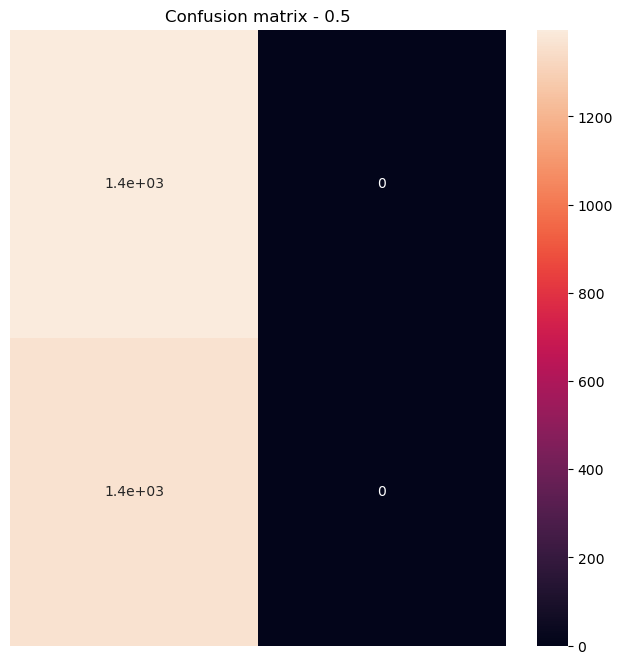

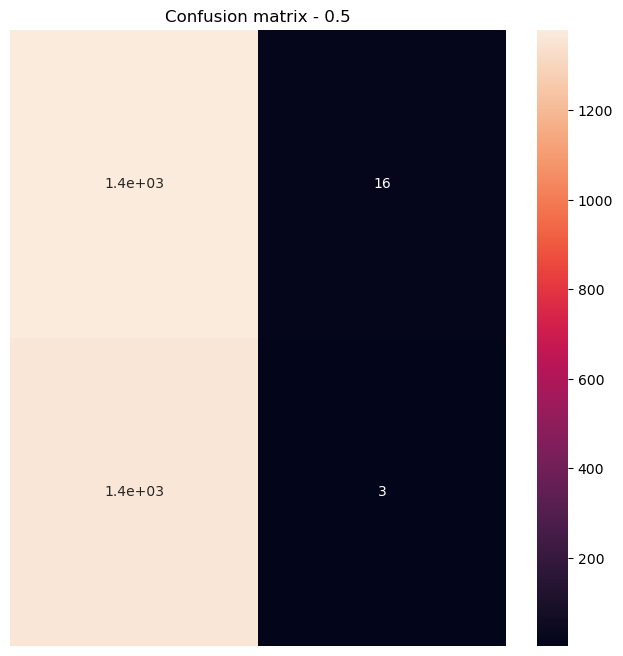

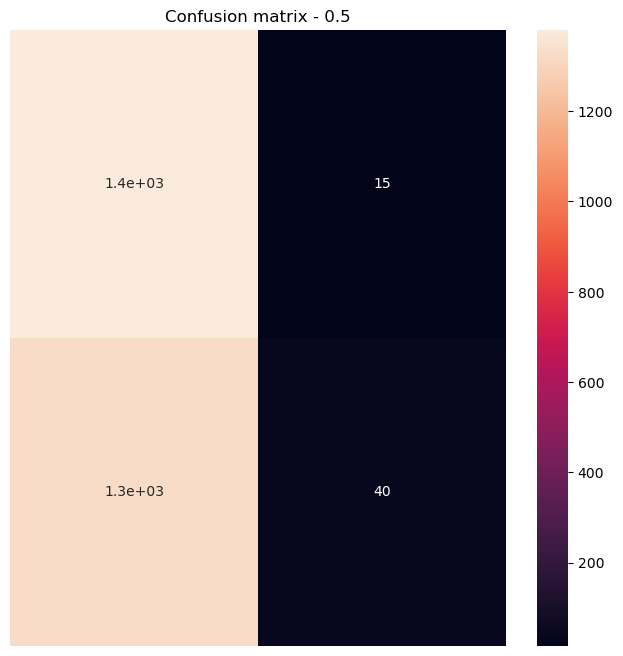

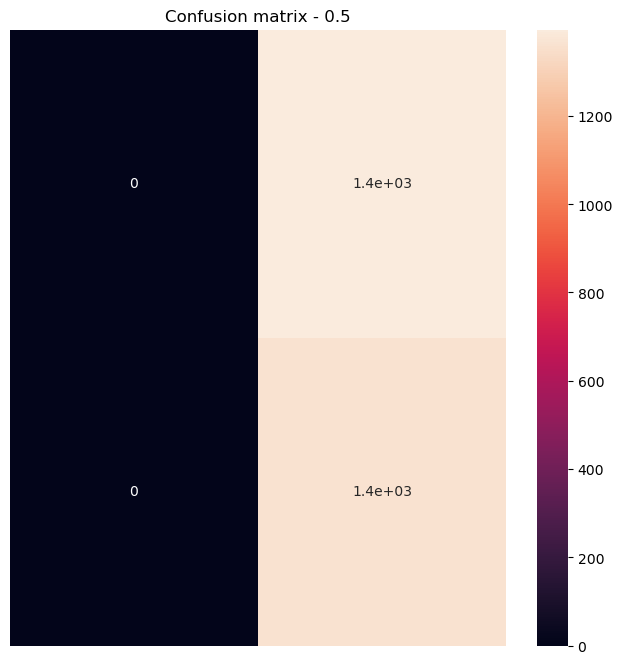

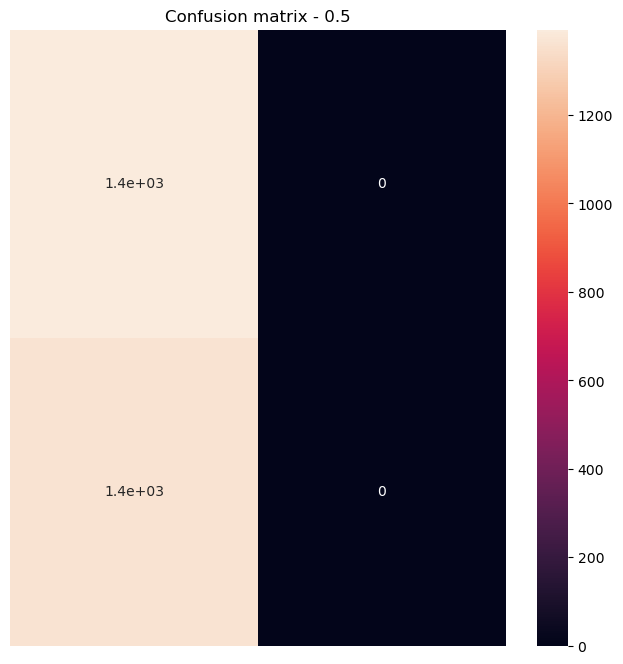

In [37]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs = 5 , verbose=1, callbacks = [tensorbourd_calback, callbacks_scheduler, LogImagesCallback()])

# Visualizations

## tensorboard

In [38]:
%load_ext tensorboard

### tensorboard --logdir='./logs' --host=127.0.0.1 --port=6006 ## port [6000, 7000]

In [39]:
tensorboard --logdir='./logs' --host=127.0.0.1 --port=6014